# Explaining cortical thickness development: IMAGEN CT data

Note: As IMAGEN data is under data protection, no IMAGEN data is included in this repo. To run this notebook on your own, you have to apply for [access](https://nda.nih.gov/abcd/request-access.html) to the IMAGEN data, which is only possibly via a specific project proposal. We processed the structural MRI data on our own with Freesurfer 7.1.1. This notebook extracts the required CT data from standard Freesurfer subject folders run with the standard -recon all pipeline. If you want to use it on your own, you will have to change the data paths. 

If you have successfully gained access to the IMAGEN data and would like to use our Freesurfer data, please feel free to contact me at [leondlotter@gmail.com](mailto:leondlotter@gmail.com)!

For data protection, no individual-subject data are shown in this notebook (lines are commented out). 

In [1]:
import os

import numpy as np
import pandas as pd
from functools import reduce
from glob import glob

from os.path import join
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import iqr

# custom functions
from scripts.braincharts import get_adapted_predictions #  wrappers around PCNtoolkit/braincharts
from scripts.templates import get_destrieux
from scripts.utils import reorder_vars, na
from scripts.freesurfer_stats import collect_fs_stats

# working path
wd = os.path.dirname(os.path.realpath("__file__"))
print("Working directory:", wd)

# IMAGEN data paths
imgn_data_dir = "/Users/llotter/data/imagen/freesurfer"
imgn_pheno_dir = "/Users/llotter/data/imagen/pheno/data/imagen/2.7"
imgn_dir = join(wd, "data_ABCD-IMGN")

# cortical thickness model path
ct_model_dir = join(wd, "model_rutherford", "lifespan_57K_82sites")

Working directory: /Users/llotter/projects/CTdev


## Get data

#### Destrieux idps

In [3]:
# parcel labels
destrieux_idps = get_destrieux()[1]

#### Tab keys

In [5]:
# DAWBA - diagnoses
dawba_keys_orig = pd.read_csv(join(imgn_pheno_dir, "BL", "dawba", "IMAGEN_dawba_BL.csv"), 
                              low_memory=False).columns
dawba_keys_orig = [c for c in dawba_keys_orig if c.startswith("dc")] 
dawba_keys = ["dawba_" + k[2:] for k in dawba_keys_orig]

# GEN - ethnicity
gen_keys = ["PF_ethnicity", "PM_ethnicity"]

#### Get phenotypic data

In [6]:
imgn = {}
for tp, fu in zip(["T0", "T5", "T8"], ["BL", "FU2", "FU3"]):
    
    imgn_tab_data = {
        join(imgn_pheno_dir, fu, "dawba", "IMAGEN_dawba_*.csv"):  ["sstartdate"] + dawba_keys_orig,
        join(imgn_pheno_dir, fu, "psytools", "IMAGEN-IMGN_GEN_RC5-BASIC_DIGEST.csv"):  gen_keys,
    }
    
    imgn[tp] = []
    for i, k in enumerate(imgn_tab_data):
        
        # read file
        try:
            temp = pd.read_csv(glob(k)[0], low_memory=False)
        except:
            continue
        # get ID column and variables of interest
        if "PSC2" in temp.columns:
            temp = temp[["PSC2"] + imgn_tab_data[k]].rename(columns={"PSC2": "id"})
        elif "User code" in temp.columns:
            temp = temp[["User code"] + imgn_tab_data[k]].rename(columns={"User code": "id"})
        else:
            print("ID column not found!")
        # clean ID column
        try:
            temp.id = [int(i.replace("-C", "").replace("-I", "")) for i in temp.id]
        except:
            pass
        temp.id = [f"sub-{sub:012d}" for sub in temp.id]
        # add timepoint column
        temp = temp.assign(tp=tp)
        # save
        imgn[tp].append(temp)
    
    # combine data
    imgn[tp] = reduce(lambda  left, right: pd.merge(left, right, on=["id", "tp"], how='left'), 
                      imgn[tp])
    
    # index
    imgn[tp] = imgn[tp].set_index(["id", "tp"], drop=False)
    imgn[tp].index.names = ["idx_id", "idx_tp"]
        
    # age  
    imgn[tp] = imgn[tp].rename(columns={"sstartdate": "age"})
    imgn[tp].age = imgn[tp].age.astype("str")
    imgn[tp].age = [float(a.split("/")[0]) for a in imgn[tp].age]
    imgn[tp].age = (imgn[tp].age / 365).round(2)
    
    print(f"{tp}: N = {imgn[tp].shape[0]}, mean age = {imgn[tp].age.mean():.02f}")

# combine
imgn = pd.concat([imgn[k] for k in imgn.keys()])
imgn = imgn.sort_index(axis="index")
#imgn

T0: N = 2224, mean age = 14.46
T5: N = 1525, mean age = 19.02
T8: N = 1315, mean age = 22.58


##### Rename and create new variables

In [7]:
# add sex and site
temp = pd.read_csv(join(imgn_pheno_dir, "FU3", "participants", "IMAGEN_demographics.csv")) \
    .rename(columns={"PSC2": "id", "recruitment centre": "site_str", "sex": "sex_str"})
temp.id = [f"sub-{sub:012d}" for sub in temp.id]
temp = temp.set_index("id", drop=True)
for sub in imgn.id.unique():
    try:
        imgn.loc[(sub, na()), "sex_str"] = temp.loc[sub, "sex_str"]
        imgn.loc[(sub, na()), "site_str"] = temp.loc[sub, "site_str"]
    except:
        pass
imgn["sex"] = [0 if s=="F" else 1 for s in imgn.sex_str]
imgn["site"] = pd.factorize(imgn.site_str)[0] + 1
imgn.site = np.where(imgn.site_str.isnull(), pd.NA, imgn.site)

# rename remaining variables
imgn = imgn.rename(columns=dict(zip(dawba_keys_orig, dawba_keys)))

# remove T5 data of one subject that seemed to be scanned with only weeks between T5 and T8
imgn = imgn.drop(("sub-000028982808", "T5"), axis="index")
# remove T5 data of one subject that has an age in the T8 range at T5
imgn = imgn.drop(("sub-000032585091", "T5"), axis="index")

# remove rows with missing age, sex, or site
imgn = imgn.loc[~imgn[["age", "sex", "site"]].isnull().any("columns"), :]

#imgn

### CT data

#### Get FS data

In [8]:
# all subjects/sessions with their original names (a lot of those dont have fs data)
subs = [i+"_ses-"+ses for i in imgn.id for ses in ["BL", "FU2", "FU3"]]
# drop subjects/sessions that have incomplete data 
subs = [s for s in subs if s not in \
    ['sub-000008337444_ses-BL',
     'sub-000027798877_ses-FU3',
     'sub-000047975799_ses-FU2',
     'sub-000064999269_ses-BL',
     'sub-000083308215_ses-BL',
     'sub-000090579038_ses-BL']]
fs_data = collect_fs_stats(imgn_data_dir, subs, parc="destrieux", verbose=False, return_as_df=True)

# remake/rename index
fs_data["idx_id"] = [i.split("_")[0] for i in fs_data.index]
fs_data["idx_tp"] = [i.split("-")[-1] for i in fs_data.index]
fs_data["idx_tp"] = fs_data["idx_tp"].replace({"BL":"T0", "FU2":"T5", "FU3":"T8"})
fs_data = fs_data.set_index(["idx_id", "idx_tp"], drop=True)
fs_data.columns = [c.replace("_and_", "&") for c in fs_data.columns]

#fs_data

#### Combine data

In [9]:
print(f"Original: {imgn.shape[0]} observations, {len(imgn.id.unique())} subjects")

imgn = imgn.merge(
    fs_data[["lh_en", "rh_en", "total_en", "EstimatedTotalIntraCranialVol"] + destrieux_idps], 
    how="left", left_index=True, right_index=True
)

imgn = imgn.loc[~imgn[destrieux_idps + ["EstimatedTotalIntraCranialVol"]].isnull().any("columns"), :]
print(f"Complete CT data: {imgn.shape[0]} observations, {len(imgn.id.unique())} subjects")

# reorder variables
imgn = reorder_vars(["id", "tp", "site", "site_str", "age", "sex", "sex_str"], imgn, destrieux_idps)

Original: 4990 observations, 2158 subjects
Complete CT data: 3975 observations, 1528 subjects


## QC

In [10]:
qc_thresh = "iqr"

# get outlier threshold
if qc_thresh=="quantile":
      thresh = np.quantile(imgn.total_en, 0.99)
elif qc_thresh=="iqr":
      q3 = np.percentile(imgn.total_en, 75)
      thresh = q3 + 1.5 * iqr(imgn.total_en)
elif qc_thresh=="sd":
      mean = np.mean(imgn.total_en)
      sd = np.std(imgn.total_en)
      thresh = mean + 3*sd
imgn["topo_thresh"] = thresh
# get outliers
imgn["topo_outlier"] = imgn.total_en > imgn.topo_thresh
print(f"Pre QC: {imgn.shape[0]} observations, {len(imgn.id.unique())} subjects")

# drop outlier subjects
imgn_preqc = imgn.copy()
imgn = imgn.query("topo_outlier==False").copy()
print(f"Post QC: {imgn.shape[0]} observations, {len(imgn.id.unique())} subjects")

# subjects that have longitudinal data after QC
imgn[["tp_T0T8", "tp_T0T5", "tp_T5T8", "tp_one"]] = pd.NA
for sub in imgn.id.unique():
      temp = imgn.tp[(sub, na())].to_list()
      # T0 - T8
      imgn.loc[(imgn.id==sub) & (imgn.tp!="T5"), "tp_T0T8"] = True if ("T0" in temp) & ("T8" in temp) else pd.NA
      # T0 - T5
      imgn.loc[(imgn.id==sub) & (imgn.tp!="T8"), "tp_T0T5"] = True if ("T0" in temp) & ("T5" in temp) else pd.NA
      # T5 - T8
      imgn.loc[(imgn.id==sub) & (imgn.tp!="T0"), "tp_T5T8"] = True if ("T5" in temp) & ("T8" in temp) else pd.NA
      # only one timepoint
      imgn.loc[(sub, temp[0]), "tp_one"] = True if len(temp)==1 else pd.NA

Pre QC: 3975 observations, 1528 subjects
Post QC: 3732 observations, 1522 subjects


## TD subjects and Psychopathology

##### TD subjects

In [11]:
# any subject with psychiatric diagnoses (no info on medical diagnoses)
temp = \
      (imgn.dawba_any != 0)
      
# invert list -> True == TD
temp = ~temp

# list of all subjects
subs = imgn.id.unique().tolist()
# iterate subjects
for sub in subs:
      # a subject is TD if it is TD at all available timepoints
      imgn.loc[(sub, na()), "td"] = "TD" if temp.loc[(sub, na())].all() else "NTD"
      
for tp in ["T0", "T5", "T8"]:
      print(f"{tp}: {len(imgn[(imgn.td=='TD') & (imgn.tp==tp)])} TD & " 
            f"{len(imgn[(imgn.td=='NTD') & (imgn.tp==tp)])} NTD")

T0: 922 TD & 404 NTD
T5: 910 TD & 402 NTD
T8: 743 TD & 351 NTD


### Adaptation subjects

We select 20 adaptation subjects from each site: To retain more subjects for longitudinal analyses, we use only those that have no second time point. Subjects are taken from the "TD" cohort defined as having no severe medical or psychiatric condition. Selected subjects are stratified by age (grouped in 0.5-year bins) and split by sex (50/50)

In [12]:
# Find adaptation subjects
n_adapt = 20
print(f"Selecting n = {n_adapt} random adaption subjects from TDs, stratified on age, 50/50 male/female")

# form 0.5 year age bins
imgn["age_group"] = pd.cut(
    imgn.age, 
    bins=list(np.arange(13,25.1,0.5)),
    labels=[f">{i}<={i+0.5}" for i in np.arange(13,25,0.5)])

# new variable
imgn["adapt"] = False

# iterate sites
for site in imgn.site.unique():
    # iterate sexes
    for sex in ["F", "M"]:
        
        # df from which subjects are drawn (subjects with T0 but no T2 to keep study cohort large) 
        temp = imgn.loc[(imgn.site==site) & (imgn.td=="TD") & (imgn.tp=="T0") & (imgn.sex_str==sex), :].copy()
        # drop age groups with less than two subjects 
        for group in temp.age_group.unique():
            if len(temp[temp.age_group==group])==1:
                print(f"Dropping group {group}, n = {len(temp[temp.age_group==group])}")
                temp = temp[temp.age_group!=group]
        print(f"Site: {site}, n({sex}) = {len(temp)}")
        # select adaptation subjects if enough subjects available for site and sex
        if len(temp) > int(n_adapt/2):
            adapt, _ = train_test_split(
                temp.id,
                stratify=temp["age_group"],
                train_size=int(n_adapt/2),
                random_state=42)
        # if not, just use all
        else:
            adapt = temp.id 
            
        # store if adaptation subject
        imgn.loc[(adapt.to_list(), ), "adapt"] = True
    
    print(f"n(adapt) = {len(imgn[(imgn.site==site) & (imgn.adapt==True) & (imgn.tp=='T0')])}")
           
print("Number of adaptation subjects (tp's combined):", len(imgn[(imgn.adapt==True) & (imgn.tp=="T0")]))

Selecting n = 20 random adaption subjects from TDs, stratified on age, 50/50 male/female
Site: 3, n(F) = 65
Dropping group >13.0<=13.5, n = 1
Site: 3, n(M) = 68
n(adapt) = 20
Site: 1, n(F) = 65
Site: 1, n(M) = 76
n(adapt) = 20
Dropping group >15.0<=15.5, n = 1
Site: 4, n(F) = 57
Site: 4, n(M) = 68
n(adapt) = 20
Site: 2, n(F) = 66
Dropping group >13.5<=14.0, n = 1
Site: 2, n(M) = 60
n(adapt) = 20
Site: 5, n(F) = 60
Site: 5, n(M) = 63
n(adapt) = 20
Site: 6, n(F) = 48
Site: 6, n(M) = 53
n(adapt) = 20
Site: 7, n(F) = 47
Dropping group >13.0<=13.5, n = 1
Site: 7, n(M) = 49
n(adapt) = 20
Site: 8, n(F) = 33
Dropping group >15.0<=15.5, n = 1
Site: 8, n(M) = 39
n(adapt) = 20
Number of adaptation subjects (tp's combined): 160


### Sample stats

In [13]:
print("Overall number of unique subjects: n =", len(imgn[imgn.adapt==False].id.unique()))

imgn["sex_str"] = pd.Categorical(imgn.sex_str)
imgn_sample_stats = dict()
for tp in ["T0", "T5", "T8"]:
    imgn_sample_stats[("Test", tp, "Age [y]")] = imgn.loc[(imgn.adapt==False) & (imgn.tp==tp), "age"].describe()
    imgn_sample_stats[("Test", tp, "Male [%]")] = pd.Series({
        "count": len(imgn.loc[(imgn.adapt==False) & (imgn.tp==tp)].sex_str),
        "%": len(imgn.loc[(imgn.adapt==False) & (imgn.tp==tp) & (imgn.sex_str=="M")]),
    })
    if tp=="T0":
        imgn_sample_stats[("Adaptation", tp, "Age")] = imgn.loc[(imgn.adapt==True) & (imgn.tp==tp), "age"].describe()
        imgn_sample_stats[("Adaptation", tp, "Male [%]")] = pd.Series({
            "count": len(imgn.loc[(imgn.adapt==True) & (imgn.tp==tp)].sex_str),
            "%": len(imgn.loc[(imgn.adapt==True) & (imgn.tp==tp) & (imgn.sex_str=="M")]),
        })
imgn_sample_stats = pd.DataFrame(imgn_sample_stats).sort_index(axis=1)
imgn_sample_stats = imgn_sample_stats.loc[["count", "mean", "%", "std", "50%", "min", "max"],:]
imgn_sample_stats = imgn_sample_stats.rename(index={"count":"n", "50%":"median", "std":"sd"})
imgn_sample_stats.loc["%",:] = imgn_sample_stats.loc["%",:] / imgn_sample_stats.loc["n",:] * 100
imgn_sample_stats = imgn_sample_stats.round(2)
imgn_sample_stats.to_csv(join(imgn_dir, "imgn_samplestats.csv"))
imgn_sample_stats

Overall number of unique subjects: n = 1362


Adaptation              Test                                     \
               T0                T0                T5               T8   
              Age Male [%]  Age [y] Male [%]  Age [y] Male [%] Age [y]   
n          160.00    160.0  1166.00  1166.00  1177.00  1177.00  985.00   
mean        14.43      NaN    14.45      NaN    19.00      NaN   22.55   
%             NaN     50.0      NaN    46.91      NaN    47.32     NaN   
sd           0.39      NaN     0.40      NaN     0.78      NaN    0.67   
median      14.40      NaN    14.42      NaN    18.79      NaN   22.42   
min         13.52      NaN    13.26      NaN    17.74      NaN   20.73   
max         15.30      NaN    15.71      NaN    22.55      NaN   25.11   

                 
                 
       Male [%]  
n        985.00  
mean        NaN  
%         46.09  
sd          NaN  
median      NaN  
min         NaN  
max         NaN

## Save dataframe

In [14]:
# reorder variables
imgn = reorder_vars(["id", "tp", "tp_T0T5", "tp_T0T8", "tp_T5T8", "tp_one", 
                        "site", "site_str", "adapt", 
                        "age", "age_group", 
                        "sex", "sex_str",
                        "td"],
                        imgn,
                        destrieux_idps)
# sort rows
imgn = imgn.sort_index(axis="index")
# save QC dataframe
imgn.reset_index(drop=True).to_feather(join(imgn_dir, "imgn.ftr"))

## Overview plots

### QC

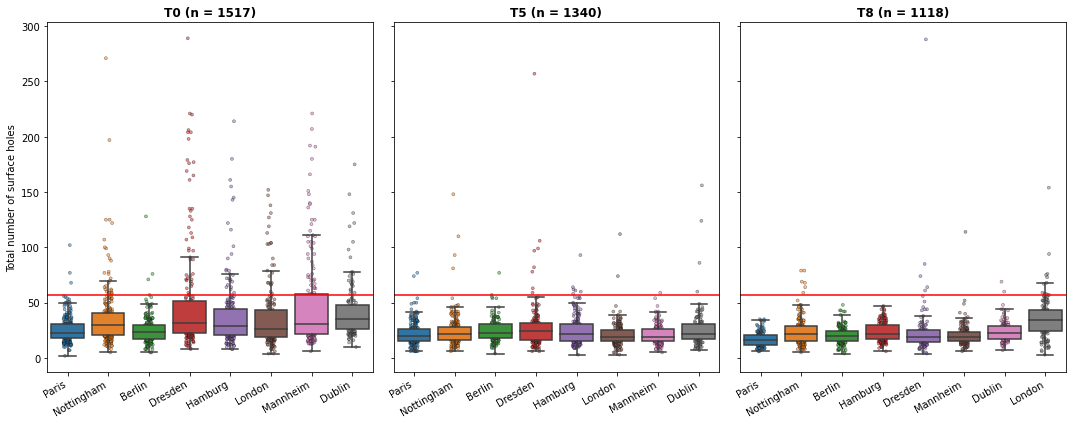

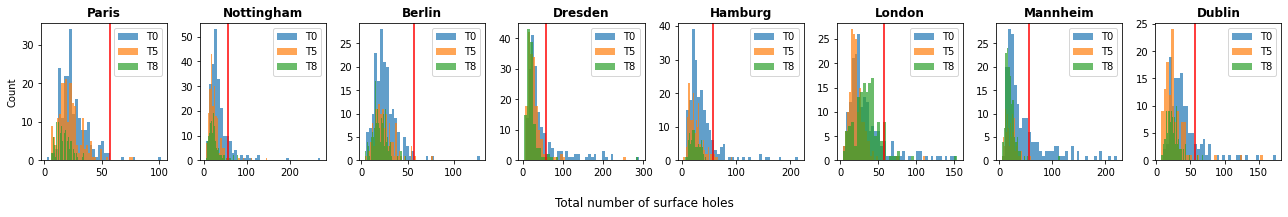

In [15]:
## Boxplots

fig, axes = plt.subplots(1,3, figsize=(15,6), sharey=True)

# iterate timepoints
for i, tp in enumerate(["T0", "T5", "T8"]):
    # data prior to QC at given TP
    data = imgn_preqc.query("(tp==@tp)")
    # scatters
    sns.stripplot(
        y=data.total_en, 
        x=data.site_str,
        ax=axes[i],
        alpha=0.5,
        linewidth=0.5,
        edgecolor="k",
        size=3,
        zorder=0
    )
    # boxplots
    sns.boxplot(
        y=data.total_en, 
        x=data.site_str,
        ax=axes[i],
        fliersize=0,
    )
    # layout
    axes[i].set_title(f"{tp} (n = {len(data)})", weight="semibold")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Total number of surface holes" if tp=="T0" else "")
    axes[i].set_xticklabels([s.get_text().title() for s in axes[i].get_xticklabels()], rotation=30, ha="right")
    axes[i].axhline(data.topo_thresh.values[0], c="red")     
plt.tight_layout()

# save
fig.savefig(join(wd, "plots", "abcd-imgn", "qc_imgn_boxplots.pdf"))


## Histograms

fig, axes = plt.subplots(1,imgn.site.max(), figsize=(18,3))
axes = axes.ravel()

# iterate sites and tps
for i, site in enumerate(imgn.site_str.unique()):
    for tp, c in zip(["T0", "T5", "T8"], ["tab:blue", "tab:orange", "tab:green"]):
        
        # data by TP and site
        data = imgn_preqc.query("(tp==@tp) & (site_str==@site)")
        
        # plot
        axes[i].hist(
            data.total_en,
            bins=40,
            alpha=0.7,
            color=c,
            label=tp
        )
        
        # layout
        axes[i].legend()
        axes[i].set_title(site.title(), weight="semibold")
    axes[i].axvline(data.topo_thresh.values[0], c="red")
    
axes[0].set_ylabel("Count")
fig.supxlabel("Total number of surface holes")
fig.tight_layout()

# save
fig.savefig(join(wd, "plots", "abcd-imgn", "qc_imgn_histograms.pdf"))

## Get predictions by Braincharts model

We use code adapted from the notebook associated with Rutherford et al., 2022.  
We adapt the normative models to the site effects of the IMGN FreeSurfer 7.1.1 data, make predictions for the new subjects, and use the models to adjust the original CT data from the IMGN subjects for site effects. 

Sources:  
Tutorial notebook: [https://pcntoolkit.readthedocs.io/en/latest/pages/apply_normative_models.html](https://pcntoolkit.readthedocs.io/en/latest/pages/apply_normative_models.html)  

### Predict & Adapt

In [16]:
# new dataframe without adaptation subjects
imgn_pred = imgn[imgn.adapt==0].copy()

# get datasets (adaptation + all others)
data_test = imgn[imgn.adapt==False]
data_adapt = imgn[(imgn.adapt==True) & (imgn.tp=="T0")]

# adapt the Braincharts model to data and get predictions
data_pred = get_adapted_predictions(
    model_dir=ct_model_dir,
    data_test=data_test,
    data_adapt=data_adapt,
    cols_cov=["age", "sex"],
    col_site="site",
    age_bspline_min=-5, 
    age_bspline_max=110, 
    site_ids_tr=list(np.loadtxt(join(wd, "model_rutherford", "site_ids_82sites.txt"), dtype=str)), 
    idps=destrieux_idps + ["EstimatedTotalIntraCranialVol"])

Iterating IDPs:   0%|          | 0/149 [00:00<?, ?it/s]

IDP 0: lh_G&S_frontomargin_thickness
Preparing test data
Preparing adaptation data
Predict
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Adjust CT data for site effects
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Saving results
IDP 1: lh_G&S_occipital_inf_thickness
Preparing test data
Preparing adaptation data
Predict
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Adjust CT data for site effects
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Saving results
IDP 2: lh_G&S_paracentral_thickness
Preparing test data
Preparing adaptation data
Predict
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Adjust CT data for site effects
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Saving results
IDP 3: lh_G&S_subcentral_

### Save dataframe

In [17]:
# join with predicted data
imgn_pred = imgn_pred.merge(data_pred.round(3), left_index=True, right_index=True, suffixes=("", "_DUPL"))
imgn_pred = imgn_pred.drop([c for c in imgn_pred.columns if c.endswith("_DUPL")], axis="columns")

# reorder variables
imgn_pred = reorder_vars(["id", "tp", "site", "site_str", "adapt", 
                          "age", "age_group", 
                          "sex", "sex_str",
                          "td"],
                         imgn_pred,
                         destrieux_idps)

# save predictor dataframe
imgn_pred.reset_index().to_feather(join(imgn_dir, "imgn_pred.ftr"))